# Olive Oil data preprocessing

For the Olive Oil price prediction, we will need historical price data, production data and weather data. In this nb, I will create the dataset aggregating this data per Spanish region (provincia).

In [1]:
import datetime
import time
import xml.etree.ElementTree as ElementTree
from collections import defaultdict
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

The weather data was extracted in [get_weather_data.ipynb](get_weather_data.ipynb) and stored in the hdf.

This weather data contains the temperature (mean, max and min), wind max speed, and rains aggregated per province in a daily basis.

In [2]:
weather_df = pd.read_hdf('data/weather_data.hdf', 'data')

Dates manipulation: week-year variable and the year-month variable. It will add the date of the first day.

In [3]:
weeks_date = {}
for i in range(len(weather_df['week'].unique())):
    week_monday = datetime.datetime(2006, 10, 2) + datetime.timedelta(days=7 * i)
    weeks_date[f'{week_monday.isocalendar()[1]}-{week_monday.isocalendar()[0]}'] = week_monday
weather_df['week_date'] = weather_df['week'].apply(lambda x: weeks_date[x])
weather_df['year_month'] = weather_df['week_date'].apply(lambda x: f"{x.year}-{x.month:02}")

The Olive Oil price data has been extracted from https://www.juntadeandalucia.es/agriculturaypesca/observatorio/servlet/FrontController?action=Static&url=preciosOrigen.jsp&ec=subsector&subsector=33

It contains the in-origin Extra Virgin Olive Oil data for the Andalucía(south of Spain) area. Andalucía have 8 provinces but one of them doesn't sell Extra Virgin Olive Oil.

In [4]:
oil_price_df = pd.read_excel('data/junta_aceite_origen_extra_provincia.xlsx')

Here, we generate useful variables for the prediction models. The last week price, and 2-3-4-6-8 weeks before.

Also, I add the mean price in the last 4 and 8 weeks.
I will add the price in 3 weeks (for medium term prediction) and the price percentages change compared with the mean price for that week.

Finally, I'm going to fill the gaps for other provinces using the last known price (Jaén is the only one that is complete)

In [5]:
# Fill missing values
oo_df = pd.DataFrame()
for _, province_df in oil_price_df.groupby('provincia'):
    province_df = province_df.fillna(method='ffill').reset_index(drop=True)
    province_df['price-1w'] = province_df['price'].shift()
    province_df['price-2w'] = province_df['price'].shift(2)
    province_df['price-4w'] = province_df['price'].shift(4)
    province_df['price+3w'] = province_df['price'].shift(-3)
    province_df['price-6w'] = province_df['price'].shift(6)
    province_df['price-8w'] = province_df['price'].shift(8)
    province_df['price-4w_mean'] = province_df['price'].shift().rolling(window=4, min_periods=4).mean()
    province_df['price-8w_mean'] = province_df['price'].shift().rolling(window=8, min_periods=8).mean()
    province_df['price_perc'] = (province_df['price'] - province_df['price-1w']) / province_df['price-1w']
    province_df['price_perc_medium'] = (province_df['price+3w'] - province_df['price-1w']) / province_df['price-1w']
    province_df['price_perc-2w'] = (province_df['price-1w'] - province_df['price-2w']) / province_df['price-2w']
    province_df['price_perc-4w'] = (province_df['price-1w'] - province_df['price-4w']) / province_df['price-4w']
    province_df['price_perc-6w'] = (province_df['price-1w'] - province_df['price-6w']) / province_df['price-6w']
    province_df['price_perc-8w'] = (province_df['price-1w'] - province_df['price-8w']) / province_df['price-8w']
    oo_df = oo_df.append(province_df.dropna())
oo_df = oo_df.reset_index(drop=True)

Here, I will create some variables using the weather data. These variables will be the rains sum for the last 4, 13, 26 and 52 weeks. I added also the mean temperature in the last 4 week.

In [6]:
weather_df['week_nr'] = weather_df['week'].apply(lambda x: int(x.split('-')[0]))
weather_complete_df = pd.DataFrame()
weather_df = weather_df[weather_df['provincia'].isin(oo_df['provincia'].unique())]
for _, province_df in weather_df.groupby('provincia'):
    province_df = province_df.sort_values(by='week_date').reset_index(drop=True)
    province_df['prec-4w_sum'] = province_df['prec'].shift().rolling(window=4, min_periods=4).sum()
    province_df['prec-13w_sum'] = province_df['prec'].shift().rolling(window=13, min_periods=13).sum()
    province_df['prec-26w_sum'] = province_df['prec'].shift().rolling(window=13, min_periods=13).sum()
    province_df['prec-52w_sum'] = province_df['prec'].shift().rolling(window=52, min_periods=52).sum()
    province_df['tmed-4w_mean'] = province_df['tmed'].shift().rolling(window=4, min_periods=4).mean()
    
    weather_vars = ['prec-4w_sum', 'prec-13w_sum', 'prec-26w_sum', 'prec-52w_sum', 'tmed-4w_mean', 'tmin', 'tmax', 'tmed', 'prec']
    province_df_mean = province_df.groupby('week_nr', as_index=False)[weather_vars].mean()
    province_df_mean = province_df_mean.rename(columns={column: f'{column}_mean' for column in weather_vars})
    province_df = province_df.merge(province_df_mean)
    for column in weather_vars:
        province_df[f'{column}_perc'] = (province_df[column] - province_df[f'{column}_mean']) / province_df[f'{column}_mean']
        province_df = province_df.drop(columns=f'{column}_mean')
    
    weather_complete_df = weather_complete_df.append(province_df.dropna())
weather_df = weather_complete_df.reset_index(drop=True)

In [this research](https://www.juntadeandalucia.es/agriculturaypesca/ifapa/-/action/90004fc0-93fe-11df-8d8b-f26108bf46ad/e5747030-1bb8-11df-b7e2-35c8dbbe5a83/es/02f9e190-faff-11e0-929f-f77205134944/alfrescoDocument?i3pn=contenidoAlf&i3pt=S&i3l=es&i3d=e5747030-1bb8-11df-b7e2-35c8dbbe5a83&contentId=0168d10e-b05f-48ed-95fd-5061ad4972bc) it explained how temperatures below -10º can damage the olive tree. Also, temperatures below -5º can affect the olive quality, so I create a special variable which scores the possible damage to the production, something that will help the model.

In [7]:
weather_df['freeze_damage'] = weather_df['tmin'].apply(lambda x: min(np.abs(x)/10, 1) if x < 0 else 0)

In [8]:
oo_df = oo_df.merge(weather_df)

The production data was collected in [get_production_data.ipynb](get_production_data.ipynb) and stored in hdf. This data contains the production declared by Olive Oil producers aggregated by province. This production doesn't distinguish between extra virgin olive oil or other classes.

In [9]:
production_df = pd.read_hdf('data/production_df.hdf', 'data')

In [10]:
production_df = production_df[production_df['provincia'].isin(oo_df['provincia'].unique())]
production_df['month'] = production_df['year_month'].apply(lambda x: int(x[-2:]))

Let's create some variables with the production sum in the last month, and last 3, 6, 9, 12 months. I also create the percentage changes compared with the mean production for the month.

In [11]:
production_sums_df = pd.DataFrame()
for _, province_df in production_df.groupby('provincia'):
    province_df = province_df.sort_values('year_month').reset_index(drop=True)
    province_df['production_tons-1m_sum'] = province_df['production_tons'].shift()
    province_df['production_tons-3m_sum'] = province_df['production_tons'].shift().rolling(window=3, min_periods=3).sum()
    province_df['production_tons-6m_sum'] = province_df['production_tons'].shift().rolling(window=6, min_periods=6).sum()
    province_df['production_tons-9m_sum'] = province_df['production_tons'].shift().rolling(window=9, min_periods=6).sum()
    province_df['production_tons-12m_sum'] = province_df['production_tons'].shift().rolling(window=12, min_periods=12).sum()
    
    production_vars = ['production_tons-1m_sum', 'production_tons-3m_sum', 'production_tons-6m_sum', 'production_tons-9m_sum', 'production_tons-12m_sum']
    province_df_mean = province_df.groupby('month', as_index=False)[production_vars].mean()
    province_df_mean = province_df_mean.rename(columns={column: f'{column}_mean' for column in production_vars})
    province_df = province_df.merge(province_df_mean)
    for column in production_vars:
        province_df[f'{column}_perc'] = (province_df[column] - province_df[f'{column}_mean']) / province_df[f'{column}_mean']
        province_df = province_df.drop(columns=f'{column}_mean')
    
    production_sums_df = production_sums_df.append(province_df.dropna()) 
production_df = production_sums_df.dropna().reset_index(drop=True)

In [12]:
oo_df = oo_df.merge(production_df)

Let's drop some outliers (changes greater than 21% in a week)

In [13]:
oo_df = oo_df.sort_values('week_date').reset_index(drop=True)
oo_df = oo_df[(oo_df['price_perc'] < 0.21) & (oo_df['price_perc'] > -0.21)]

Plotting the production data aggregating per month. Here, we can see the seasonality of the olive campaign.

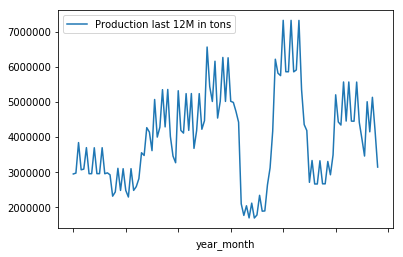

In [14]:
oo_df.groupby('year_month')['production_tons-12m_sum'].sum().plot(legend=True, label='Production last 12M in tons')

Aggregating per province we can see Jaén produces almost twice the second province

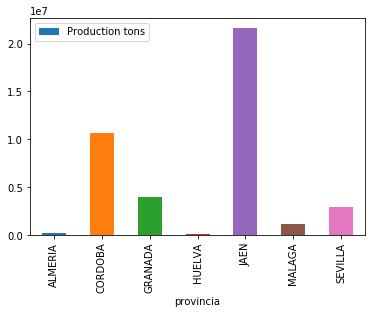

In [15]:
oo_df.groupby('provincia')['production_tons'].sum().plot.bar(label='Production tons', legend=True)

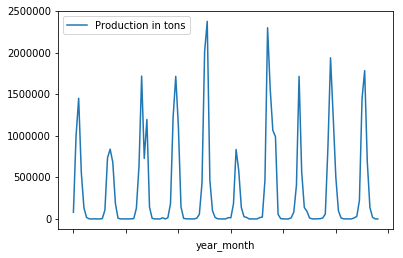

In [16]:
oo_df.groupby('year_month')['production_tons'].sum().plot(legend=True, label='Production in tons')

Let's see how the prices looks like. As we can see, there are some weird price changes probably because of the gap filling. Also, small productions doesn't behave the same than big ones. That will be difficult for the model, probably other provinces that are not Jaén and maybe Córdoba, probably will add noise to the model.

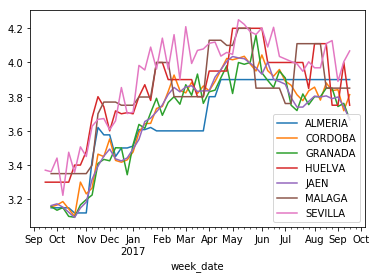

In [17]:
for provincia, df in oo_df.groupby('provincia'):
    df[-52:].set_index('week_date', drop=True)['price'].plot(label=provincia, legend=True)

Let's see how is distributed the data.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


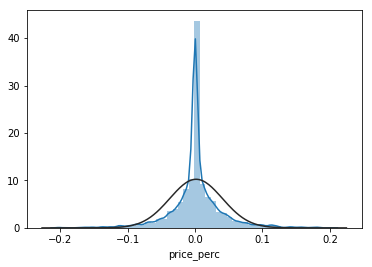

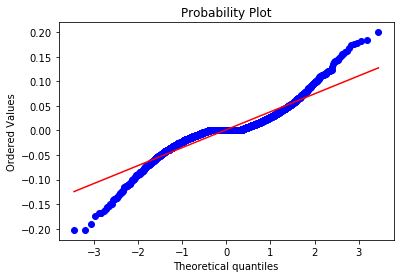

In [18]:
sns.distplot(oo_df['price_perc'], fit=norm)
fig = plt.figure()
res = stats.probplot(oo_df['price_perc'], plot=plt)

Plotting mean temperature to check the seasonality

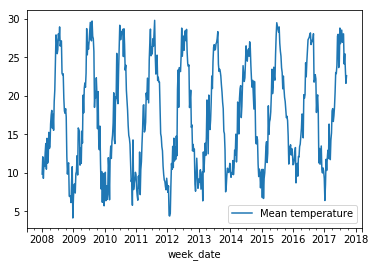

In [19]:
oo_df.groupby('week_date')['tmed'].mean().plot(legend=True, label='Mean temperature')

Plotting the rain sum for the last year compared with the price. I moved the price to have a visual comparision.

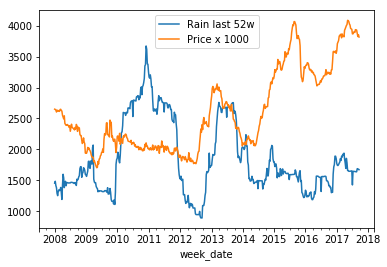

In [20]:
oo_df.groupby('week_date')['prec-52w_sum'].mean().plot(label='Rain last 52w', legend=True)
(oo_df.groupby('week_date')['price'].mean() * 1000).plot(label='Price x 1000', legend=True)

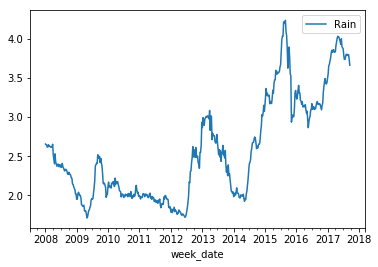

In [21]:
oo_df[oo_df['provincia'] == 'JAEN'].groupby('week_date')['price'].mean().plot(label='Rain', legend=True)

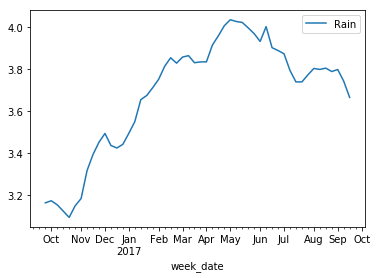

In [22]:
oo_df[oo_df['provincia'] == 'JAEN'].groupby('week_date')['price'].mean()[-52:].plot(label='Rain', legend=True)

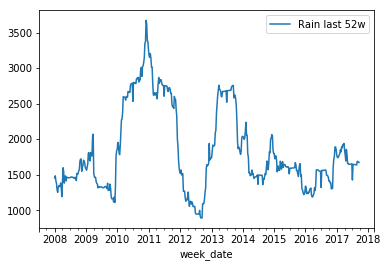

In [23]:
oo_df.groupby('week_date')['prec-52w_sum'].mean().plot(label='Rain last 52w', legend=True)

In [24]:
oo_df = oo_df.drop(columns=['year_month', 'week_date', 'week', 'production_tons'])

Let's see how correlated are the dataset features

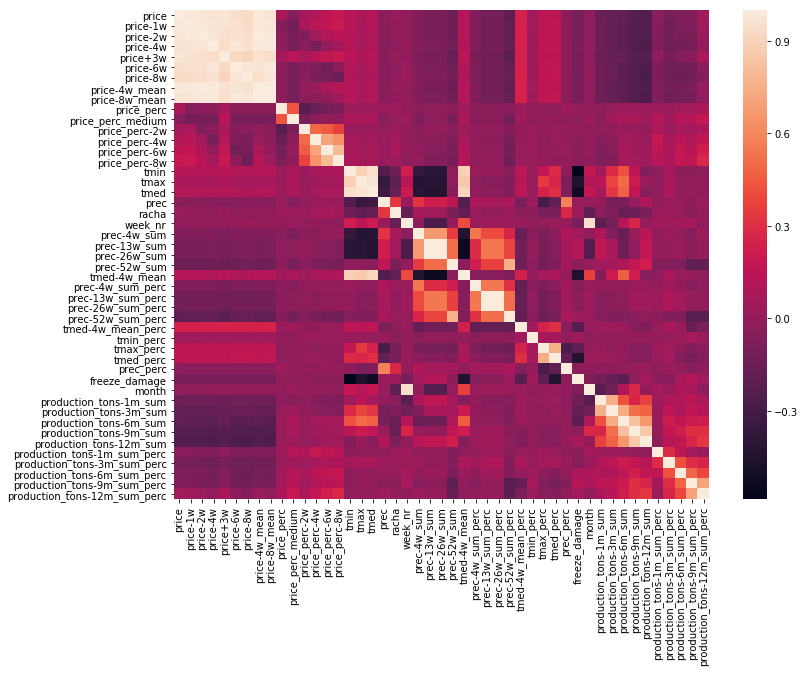

In [25]:
corrmat = oo_df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat)

In [26]:
oo_df_selected = oo_df[['price_perc',
    'price_perc-2w', 'price_perc-4w', 
    'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 'freeze_damage']]

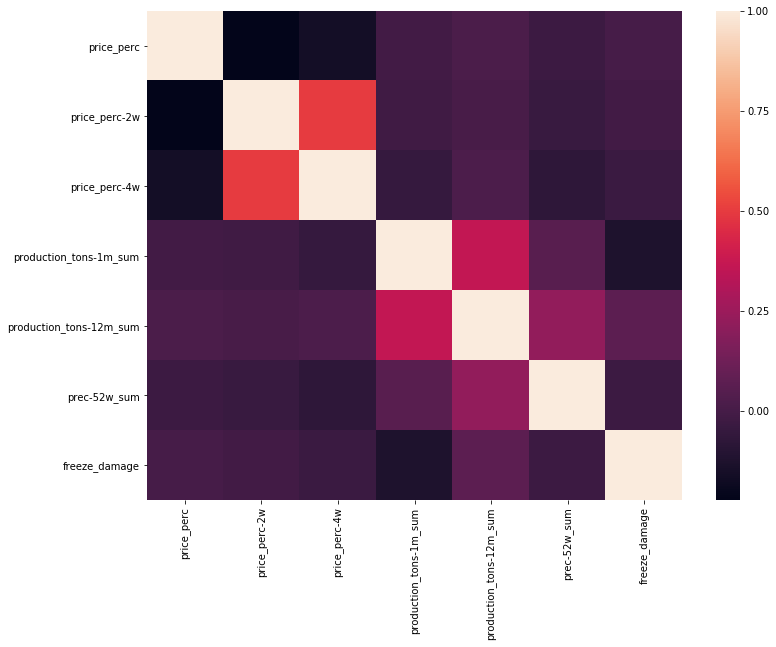

In [27]:
corrmat = oo_df_selected.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat)

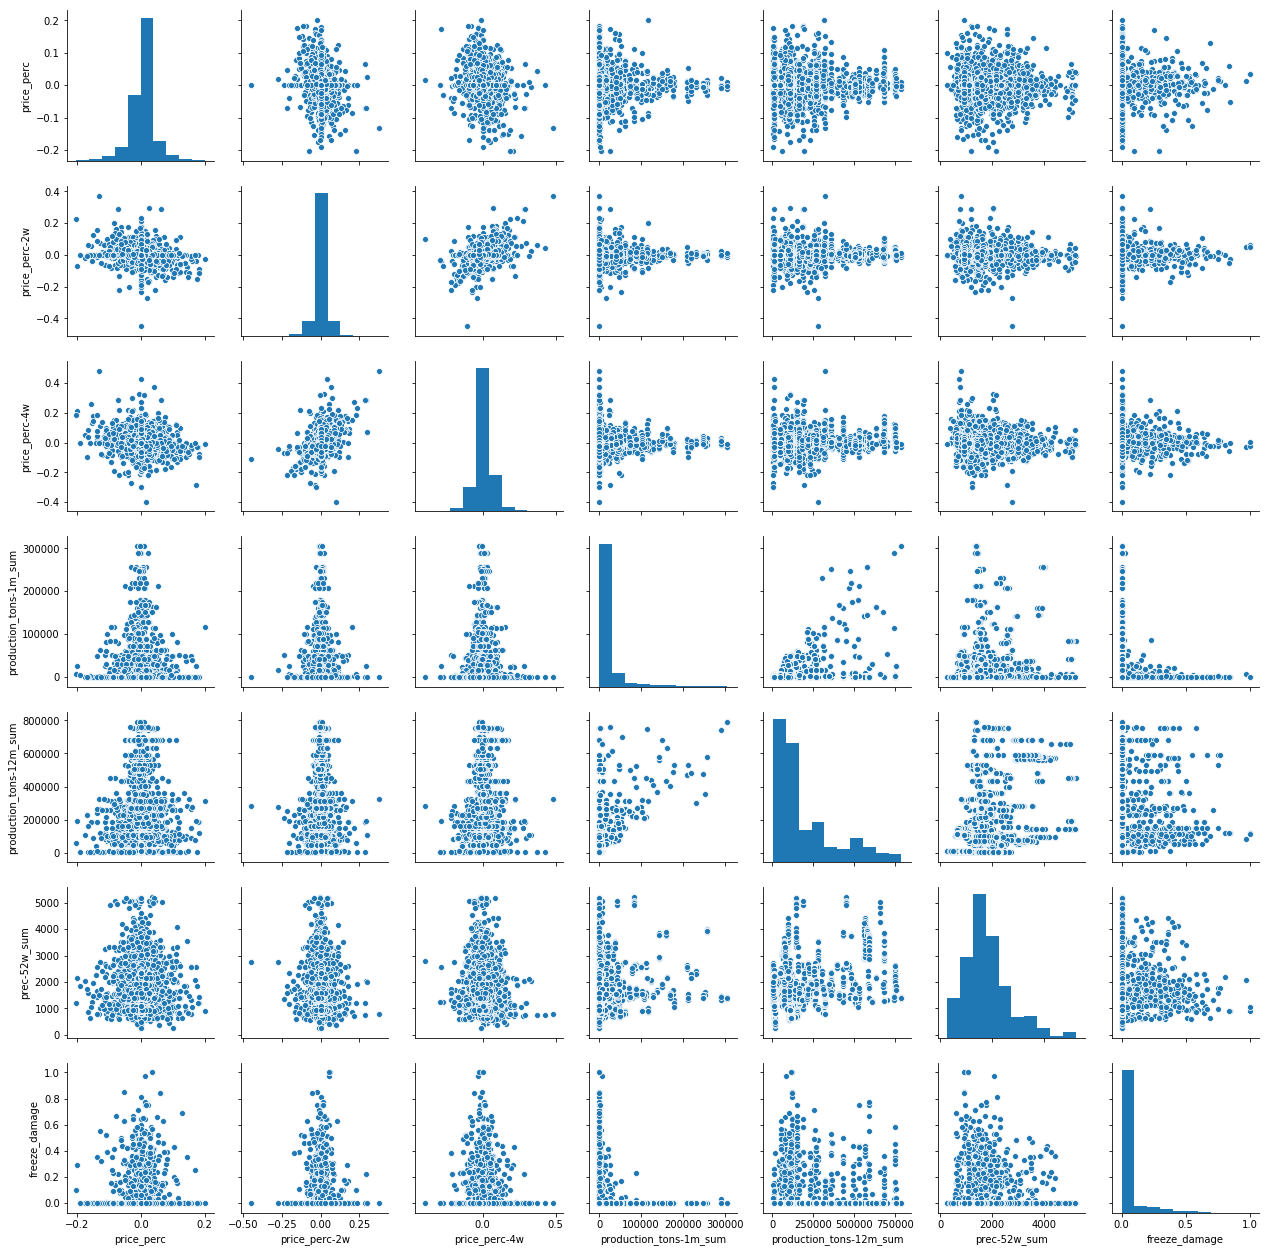

In [28]:
sns.pairplot(oo_df_selected)

Saving the data for modelling

In [ ]:
oo_df.to_hdf('data/oo_data_region.hdf', 'data')